##### Copyright 2024 Google LLC. Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License

# Data Preparation

### Step 1: Download a csv file of the embeddings using this [link](https://docs.google.com/forms/d/e/1FAIpQLSeZLIqTCIx1-OiBzUnqXZpu_k5M223ZvMmqwQhMZ_0TkaWhEQ/viewform)..

The county and ZCTA (zipcode census tabulation area) embeddings are available in different files.

Here we assume that you have obtained the embeddings and uploaded them to a Google Drive directory called `pdfm_embeddings/v0/us`.

In [2]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@markdown Specify the path to the embeddings folder.
BASE_PATH = '/content/drive/MyDrive/pdfm_embeddings/v0/us' #@param {type:"string"}

county_embeddings = pd.read_csv(BASE_PATH + 'county_embeddings.csv').set_index('place')
zip_embeddings = pd.read_csv(BASE_PATH + 'zcta_embeddings.csv').set_index('place')
embeddings = pd.concat([county_embeddings, zip_embeddings])

In [4]:
embedding_features = [f'feature{x}' for x in range(330)]
embeddings.head(2)

,state,county,population,latitude,longitude,feature0,feature1,feature2,feature3,feature4,...,feature321,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329,city
place,,,,,,,,,,,,,,,,,,,,,
geoId/01001,AL,Autauga County,58761,32.532237,-86.646439,-0.059204,1.153834,0.286746,0.324178,1.003599,...,-0.165617,0.816348,-0.167234,2.099072,-0.168644,1.155944,1.620912,-0.089127,4.831956,NaN
geoId/01003,AL,Baldwin County,233420,30.659218,-87.746067,-0.089298,0.710666,0.358453,1.138983,2.012795,...,0.049021,0.892724,-0.061048,2.791007,-0.166232,0.276117,2.892894,-0.128016,4.151655,NaN


### Step 2: Download and load a few variables from data commons.

In [ ]:
!pip install datacommons_pandas --upgrade --quiet
import datacommons_pandas as dc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.4 MB/s eta 0:00:00


In [6]:
# This may take a few minutes to run.
labels = ['Count_Person',
          'Count_Person_EducationalAttainmentBachelorsDegreeOrHigher',
          'Median_Age_Person',
          'Median_Income_Household',
          'Percent_Person_WithAsthma',
          'Percent_Person_WithHighBloodPressure'
          ]
df_labels = dc.build_multivariate_dataframe(embeddings.index, labels)
print(df_labels.shape)
df_labels.head(2)

(35157, 6)


,Count_Person,Count_Person_EducationalAttainmentBachelorsDegreeOrHigher,Median_Age_Person,Median_Income_Household,Percent_Person_WithAsthma,Percent_Person_WithHighBloodPressure
place,,,,,,
geoId/01001,59285,11144,39.2,69841.0,10.0,40.6
geoId/01003,239945,52562,43.7,75019.0,9.7,38.7


In [7]:
df = embeddings.join(df_labels)
df.head(1)

,state,county,population,latitude,longitude,feature0,feature1,feature2,feature3,feature4,...,feature327,feature328,feature329,city,Count_Person,Count_Person_EducationalAttainmentBachelorsDegreeOrHigher,Median_Age_Person,Median_Income_Household,Percent_Person_WithAsthma,Percent_Person_WithHighBloodPressure
place,,,,,,,,,,,,,,,,,,,,,
geoId/01001,AL,Autauga County,58761,32.532237,-86.646439,-0.059204,1.153834,0.286746,0.324178,1.003599,...,1.620912,-0.089127,4.831956,NaN,59285,11144,39.2,69841.0,10.0,40.6


In [8]:
df['Percent_Person_WithHigherEdu'] = (df.Count_Person_EducationalAttainmentBachelorsDegreeOrHigher / df.Count_Person) * 100
df['county_id'] = df['county'] + df['state']

# Data Visualizations

## Download the county and zcta (Zipcode census tabulation area) level geojson file.

The county and zcta level geojson file are available in the same folder as the embeddings. Download the geojson file into a local folder or a folder under Google drive. Here we assume that you have downloaded the file in Google Drive folder called pdfm_embeddings/v0/us

In [9]:
import geopandas as gpd
county_geo = gpd.read_file(BASE_PATH + 'county.geojson')
zip_geo = gpd.read_file(BASE_PATH + 'zcta.geojson')

In [10]:
geo = pd.concat([county_geo, zip_geo]).set_index('place')
embeddings = gpd.GeoDataFrame(embeddings, geometry=geo.geometry)
embeddings.shape

(35157, 337)

In [11]:
embeddings.head(10)

,state,county,population,latitude,longitude,feature0,feature1,feature2,feature3,feature4,...,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329,city,geometry
place,,,,,,,,,,,,,,,,,,,,,
geoId/01001,AL,Autauga County,58761,32.532237,-86.646439,-0.059204,1.153834,0.286746,0.324178,1.003599,...,0.816348,-0.167234,2.099072,-0.168644,1.155944,1.620912,-0.089127,4.831956,NaN,"POLYGON ((-86.91743 32.66417, -86.9212 32.6565..."
geoId/01003,AL,Baldwin County,233420,30.659218,-87.746067,-0.089298,0.710666,0.358453,1.138983,2.012795,...,0.892724,-0.061048,2.791007,-0.166232,0.276117,2.892894,-0.128016,4.151655,NaN,"MULTIPOLYGON (((-87.44728 30.51503, -87.44562 ..."
geoId/01005,AL,Barbour County,24877,31.870253,-85.405103,-0.089458,1.756277,0.749515,0.796651,0.555815,...,0.346536,-0.106772,2.986117,-0.104402,-0.059600,1.893656,-0.147867,0.032731,NaN,"POLYGON ((-85.74827 31.61803, -85.54881 31.618..."
geoId/01007,AL,Bibb County,22251,33.015893,-87.127148,-0.117877,0.725561,0.436291,0.307150,1.347822,...,1.796390,-0.128314,1.395750,-0.084409,3.489884,1.249768,-0.028330,4.688914,NaN,"POLYGON ((-87.42192 33.0034, -87.42075 32.8846..."
geoId/01009,AL,Blount County,59077,33.977357,-86.566440,-0.133150,0.648858,0.592053,0.382824,1.486730,...,2.527887,-0.045288,0.530547,-0.156357,1.227069,1.439654,-0.045479,3.491446,NaN,"POLYGON ((-86.96227 33.85816, -86.96294 33.844..."
geoId/01011,AL,Bullock County,10328,32.101759,-85.717261,-0.117035,2.806025,1.099563,1.189175,0.967877,...,0.447438,-0.157858,1.946058,-0.122570,0.606265,2.234383,-0.157815,1.588531,NaN,"POLYGON ((-85.99925 32.25017, -85.99688 32.051..."
geoId/01013,AL,Butler County,18981,31.751667,-86.681969,-0.108529,1.673919,1.148241,1.325181,1.745775,...,1.281693,-0.062386,1.839026,-0.167436,0.845107,1.914397,-0.149871,0.417710,NaN,"POLYGON ((-86.90895 31.96166, -86.90581 31.694..."
geoId/01015,AL,Calhoun County,116162,33.771706,-85.822513,-0.082855,0.829127,0.612759,0.494848,1.532471,...,1.303418,-0.122186,1.185900,-0.169557,2.156946,2.527721,-0.024455,1.504771,NaN,"POLYGON ((-86.14477 33.70699, -86.14584 33.697..."
geoId/01017,AL,Chambers County,34612,32.915504,-85.394032,-0.073514,1.563702,0.844424,0.349660,1.079024,...,0.189432,-0.134250,1.278690,-0.143409,0.563725,2.600471,-0.130347,0.144824,NaN,"POLYGON ((-85.59261 33.10735, -85.59315 32.728..."


### Map out an embedding dimension spatially

In [12]:
def get_locale(df, index, states=None, counties=None):
  df = df[df.index.isin(index)]
  if not states and not counties:
    return df
  filter = df.state.isin(states)
  if counties:
    filter &= df.county.isin(counties)
  return df[filter]

In [13]:
embeddings.head(0)

,state,county,population,latitude,longitude,feature0,feature1,feature2,feature3,feature4,...,feature322,feature323,feature324,feature325,feature326,feature327,feature328,feature329,city,geometry
place,,,,,,,,,,,,,,,,,,,,,


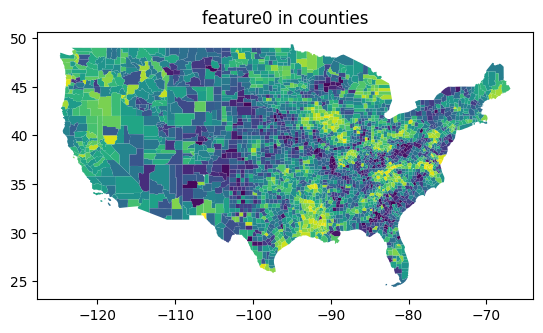

In [14]:
#@title Map out an embedding dimension feature0 spatially across all counties in US
feature = embedding_features[0]
ax = get_locale(embeddings, county_embeddings.index).plot(feature)
_ = ax.set_title(feature + ' in counties')

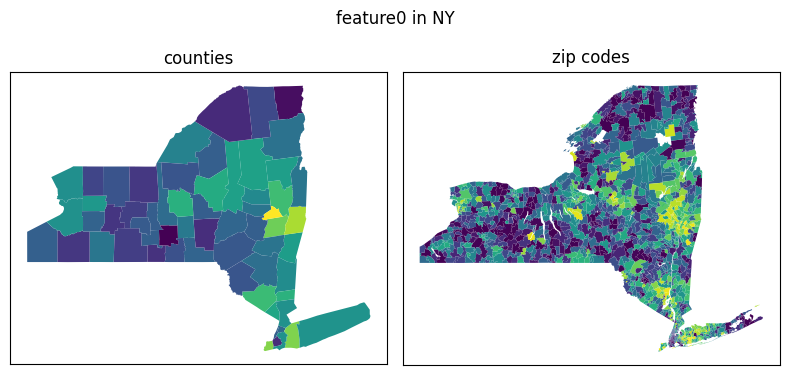

In [15]:
#@title Map out an embedding dimension feature0 spatially across all counties and zipcodes in NY state
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
state = 'NY'
get_locale(embeddings, county_embeddings.index, states=[state]).plot(feature, ax=ax[0])
get_locale(embeddings, zip_embeddings.index, states=[state]).plot(feature, ax=ax[1])
fig.suptitle(f'{feature} in {state}')
ax[0].set(title='counties')
ax[1].set(title='zip codes')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


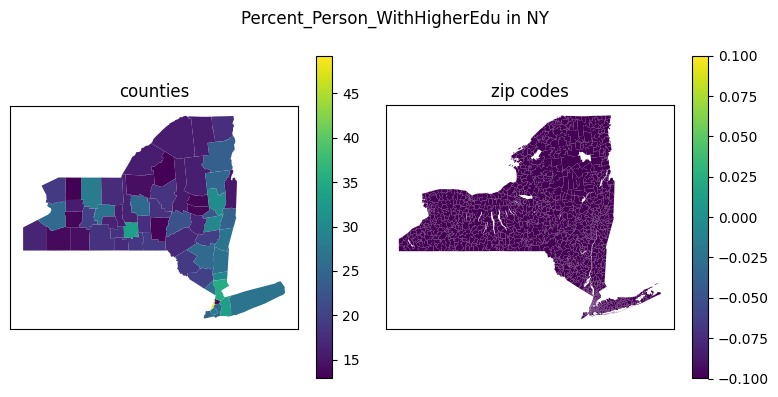

In [17]:
#@title Map out a prediction variable spatially across all counties and zipcodes in NY state
df = gpd.GeoDataFrame(df, geometry=embeddings.geometry)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
feature = 'Percent_Person_WithHigherEdu'
state = 'NY'
get_locale(df, county_embeddings.index, states=[state]).plot(feature,
    legend=True, ax=ax[0])
get_locale(df, zip_embeddings.index, states=[state]).plot(feature,
    legend=True, ax=ax[1])
fig.suptitle(f'{feature} in {state}')
ax[0].set(title='counties')
ax[1].set(title='zip codes')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

# Applying the embeddings in a prediction task

In [18]:
#@title Common imports and eval methods
import numpy as np
import math
import sklearn.metrics as skmetrics
from sklearn import linear_model, preprocessing
import lightgbm as lgbm

def evaluate(df: pd.DataFrame) -> dict:
    """Evaluates the model performance on the given dataframe.

    Args:
        df: A pandas DataFrame with columns 'y' and 'y_pred'.

    Returns:
        A dictionary of performance metrics.
    """
    # Ensure necessary columns exist and drop rows with NaN or zero in 'y'
    if not {'y', 'y_pred'}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'y' and 'y_pred' columns")

    df = df.dropna(subset=['y', 'y_pred'])
    df = df[df['y'] != 0]

    r2 = skmetrics.r2_score(df['y'], df['y_pred'])
    correlation = df['y'].corr(df['y_pred'])
    rmse = math.sqrt(skmetrics.mean_squared_error(df['y'], df['y_pred']))
    mae = skmetrics.mean_absolute_error(df['y'], df['y_pred'])
    mape = skmetrics.mean_absolute_percentage_error(df['y'], df['y_pred'])

    return {'r2': r2, 'rmse': rmse, 'mae': mae, 'mape': mape, 'correlation': correlation}


def subset_eval(label: str, county_name: str, state: str, gpred: gpd.GeoDataFrame,
                visualize: bool = True, cmap: str = 'Greys') -> dict:
    """Runs intra-county or intra-state evaluation and visualizes the results.

    Args:
        label: The label for the title of the visualization.
        county_name: The specific county name to filter.
        state: The specific state name to filter.
        gpred: GeoDataFrame containing 'y', 'y_pred', 'state', and 'county' columns.
        visualize: Whether to display visualizations.
        cmap: Colormap for visualizations.

    Returns:
        A dictionary of performance metrics.
    """
    # Apply filters based on state and county name
    subset = gpred.copy()
    if state:
        subset = subset[subset['state'] == state]
    if county_name:
        subset = subset[subset['county'] == county_name]

    # Drop rows where 'y' is NaN
    subset = subset.dropna(subset=['y', 'y_pred'])
    eval_metrics = evaluate(subset)

    if visualize:
        _, ax = plt.subplots(1, 3, figsize=(12, 4))

        # Scatter plot of predicted vs actual
        subset.plot.scatter('y', 'y_pred', alpha=0.8, ax=ax[2], color='darkgray')
        x0, x1 = subset[['y', 'y_pred']].min().min(), subset[['y', 'y_pred']].max().max()
        ax[2].plot([x0, x1], [x0, x1], ls='--', color='black')
        ax[2].set_title(f'r={eval_metrics["correlation"]:.2f}, mae={eval_metrics["mae"]:.2f}')

        # Maps of actual and predicted values
        subset.plot('y', legend=True, ax=ax[0], vmin=x0, vmax=x1, cmap=cmap,
                    legend_kwds={'fraction': 0.02, 'pad': 0.05})
        ax[0].set_title('Actual')
        subset.plot('y_pred', legend=False, ax=ax[1], vmin=x0, vmax=x1, cmap=cmap)
        ax[1].set_title('Predicted')

        plt.setp(ax[:2], xticks=[], yticks=[])
        plt.suptitle(f'{label} - {county_name}, {state}')
        plt.tight_layout()

    return eval_metrics


def make_predictions_df(predictions: np.ndarray, test_df: gpd.GeoDataFrame, label: str) -> gpd.GeoDataFrame:
    """Creates a GeoDataFrame with predictions, true labels, and geographic info.

    Args:
        predictions: A sequence of predictions.
        test_df: The original test GeoDataFrame that the predictions are based on.
        label: The column name for the true label in `test_df`.

    Returns:
        A GeoDataFrame for evaluation and visualizations.
    """
    if label not in test_df.columns:
        raise ValueError(f"The specified label '{label}' does not exist in test_df columns.")

    df_predictions = pd.DataFrame({'y': test_df[label], 'y_pred': predictions}, index=test_df.index)
    return test_df[['geometry', 'Count_Person', 'state', 'county']].join(df_predictions)


## Superresolution - Train the model on counties and make predictions for zip code.


In [19]:
#@title Train on counties and predict for zip codes
label = 'Percent_Person_WithHigherEdu'
data = df[df[label].notna() & (df.population > 500)]
train = data[data.index.isin(county_embeddings.index)]
test = data[data.index.isin(zip_embeddings.index)]

model = linear_model.Ridge()
model.fit(train[embedding_features], train[label])
predictions = model.predict(test[embedding_features])
gdf_predictions = make_predictions_df(predictions, test, label)
evaluate(gdf_predictions)

{'r2': 0.7083933390275491,
 'rmse': 6.605381418389146,
 'mae': 4.48669675154317,
 'mape': 0.529768663563929,
 'correlation': np.float64(0.8425992584447701)}

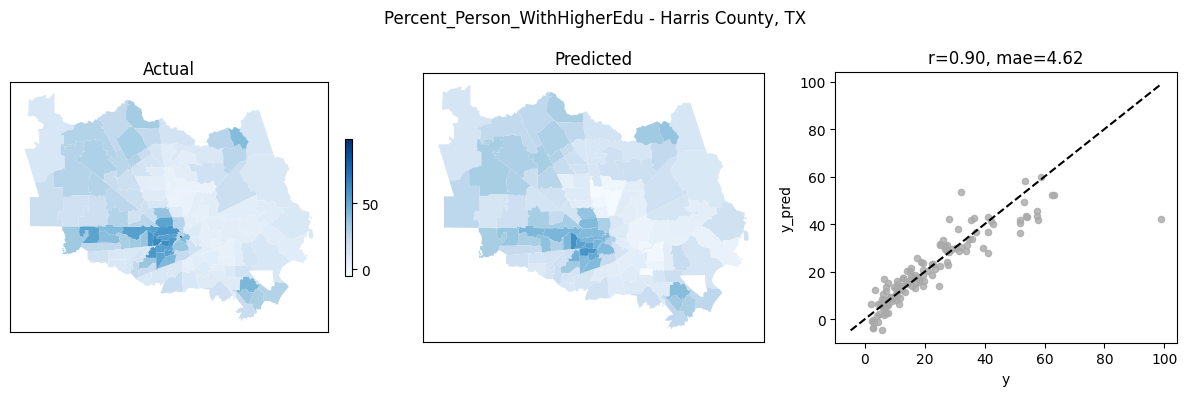

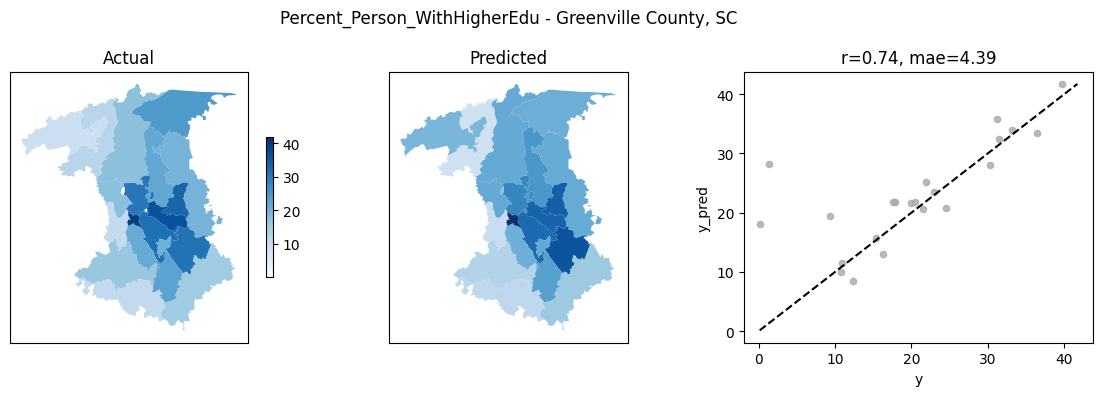

In [20]:
#@title Visualize some test set predictions
_ = subset_eval(label, 'Harris County', 'TX', gdf_predictions, cmap='Blues')
_ = subset_eval(label, 'Greenville County', 'SC', gdf_predictions, cmap='Blues')

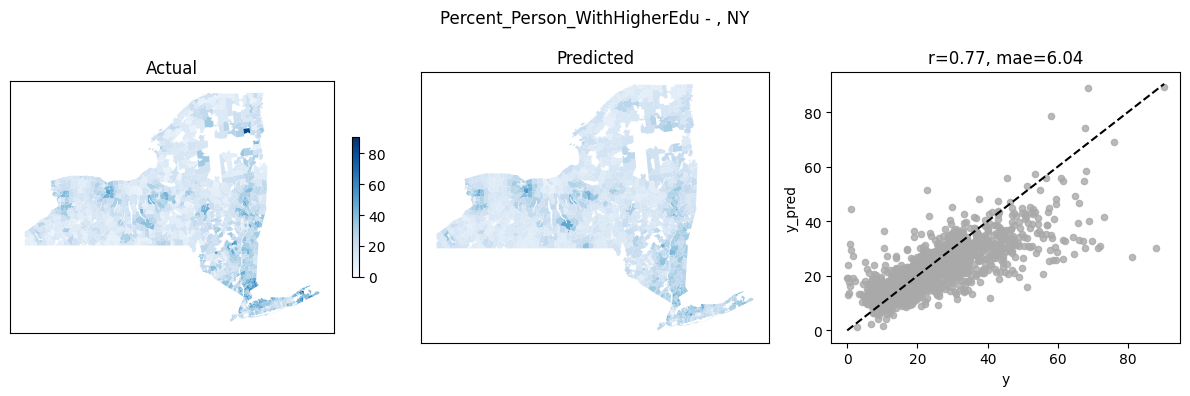

In [21]:
#@title Evaluate over a state by setting the county to an empty string.
_ = subset_eval(label, '', 'NY', gdf_predictions, cmap='Blues')

## Imputation - zip -> zip
Train on zipcodes in a subset of counties.

In [24]:
#@title train on zip codes in 20% of the counties, test on the remaining 80%.
from sklearn.pipeline import make_pipeline
import sklearn.preprocessing

def get_train_test_split(training_fraction=0.8):
  data = df[df.index.isin(zip_embeddings.index)].copy()
  # Split the zip codes by county into train/test sets.
  train_counties = data.drop_duplicates('county_id').sample(
      frac=training_fraction).county_id
  train = data[data.county_id.isin(train_counties)]
  test = data[~data.index.isin(train.index)]
  print('# training counties:', len(train_counties),
        '\n# training zip codes:', train.shape[0],
        '\n# test zip codes:', test.shape[0])
  return train, test

def run_imputation_model(
    train,
    test,
    label,
    min_population=500,
    model_class=linear_model.Ridge,
    model_kwargs={}):
  train = train[(train.population >= min_population) & train[label].notna()]
  test = test[(test.population >= min_population) & test[label].notna()]
  model = make_pipeline(preprocessing.MinMaxScaler(),
                        model_class(**model_kwargs))
  model.fit(train[embedding_features], train[label])
  predictions = model.predict(test[embedding_features])
  gdf_predictions = make_predictions_df(predictions, test, label)
  results = evaluate(gdf_predictions)
  return model, results


# Increasing this value generally improves performance.
training_fraction = 0.2
label = 'Percent_Person_WithHigherEdu'
train, test = get_train_test_split(training_fraction)
model, results = run_imputation_model(train, test, label)
results

# training counties: 618 
# training zip codes: 6545 
# test zip codes: 25524


{'r2': 0.7588689163467773,
 'rmse': 5.9797206902201125,
 'mae': 4.11946737697268,
 'mape': 0.43160316918436514,
 'correlation': np.float64(0.8723170700492698)}

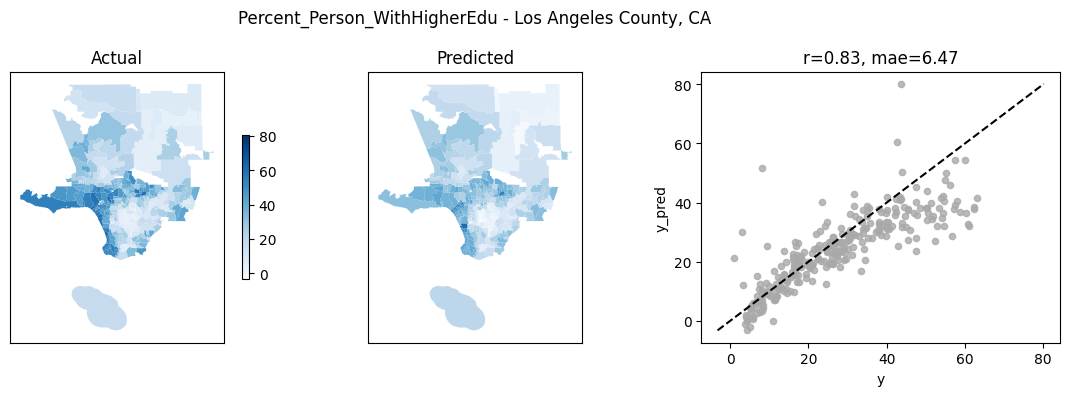

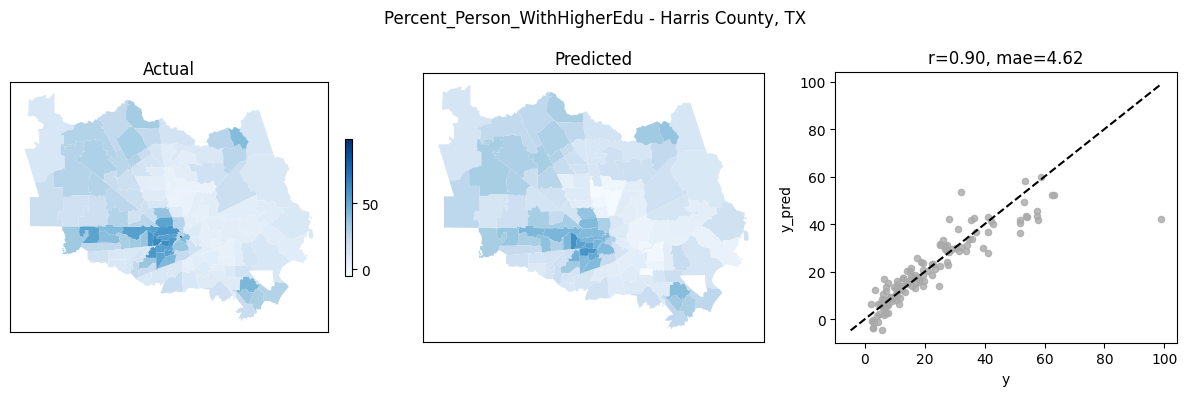

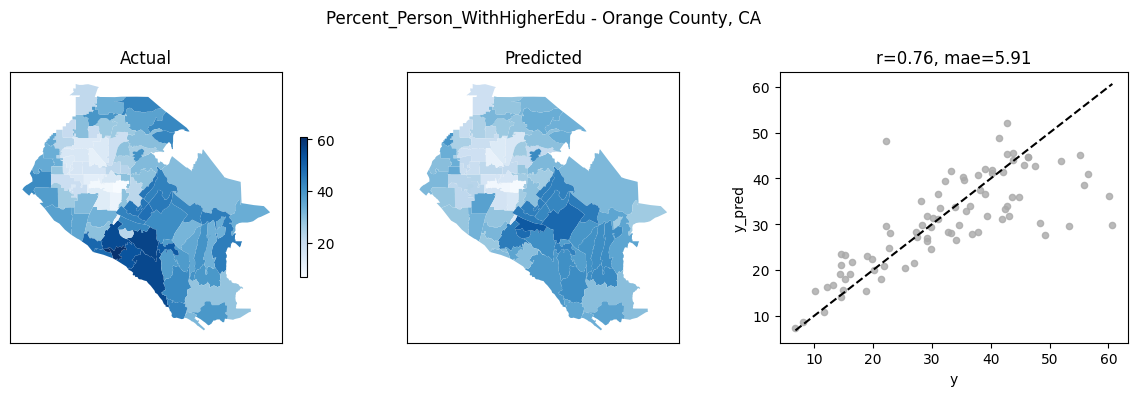

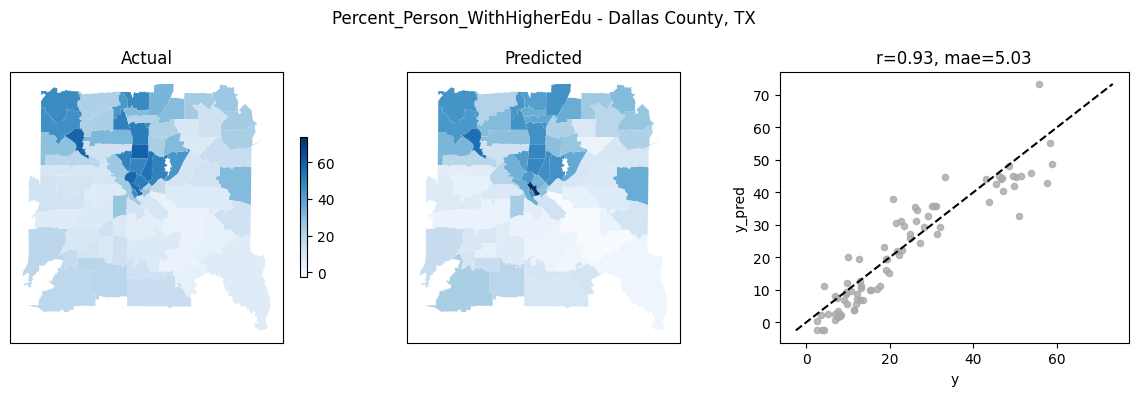

In [25]:
#@title Visualize a few counties from the test set.
test_counties = test.county_id.unique()
large_counties = df[df.county_id.isin(test_counties)].sort_values(
    'population', ascending=False)[['state', 'county', 'population']].head(4)
for _, row in large_counties.iterrows():
  _ = subset_eval(label, row.county, row.state, gdf_predictions, cmap='Blues')

In [26]:
#@title Try other labels.
labels = [
          'Percent_Person_WithHigherEdu',
          'Median_Age_Person',
          'Median_Income_Household',
          'Percent_Person_WithAsthma',
          'Percent_Person_WithHighBloodPressure'
]
train, test = get_train_test_split(0.8)
models_by_label = {}
metrics_df = pd.DataFrame(
    columns=['label', 'r2', 'rmse', 'mae', 'mape', 'model'])
for label in labels:
  models_by_label[label], results = run_imputation_model(train, test, label)
  results['label'] = label
  results['model'] = 'linear'
  metrics_df.loc[len(metrics_df)] = results

metrics_df.round(3)

# training counties: 2470 
# training zip codes: 25252 
# test zip codes: 6817


,label,r2,rmse,mae,mape,model
0,Percent_Person_WithHigherEdu,0.777,5.909,3.984,0.374,linear
1,Median_Age_Person,0.498,5.743,4.160,0.105,linear
2,Median_Income_Household,0.741,16076.997,11107.250,0.171,linear
3,Percent_Person_WithAsthma,0.705,0.659,0.485,0.045,linear
4,Percent_Person_WithHighBloodPressure,0.787,3.192,2.322,0.072,linear


In [ ]:
#@title Try LightGBM models instead of linear.

# This will take a few minutes to run.
models_by_label_lgbm = {}
metrics_df_lgbm = pd.DataFrame(
    columns=['label', 'r2', 'rmse', 'mae', 'mape', 'model'])
for label in labels:
  models_by_label_lgbm[label], results = run_imputation_model(
      train, test, label, model_class=lgbm.LGBMRegressor,
      model_kwargs={'min_child_samples': 40,
                    'importance_type': 'gain',
                    'n_estimators': 400,
                    'learning_rate': 0.04,
                    'force_col_wise': True,
                    })
  results['label'] = label
  results['model'] = 'lgbm'
  metrics_df_lgbm.loc[len(metrics_df_lgbm)] = results

metrics_df_lgbm.round(3)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 83912
[LightGBM] [Info] Number of data points in the train set: 20581, number of used features: 330
[LightGBM] [Info] Start training from score 18.919364


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 83912
[LightGBM] [Info] Number of data points in the train set: 20581, number of used features: 330
[LightGBM] [Info] Start training from score 42.191633


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 83912
[LightGBM] [Info] Number of data points in the train set: 20475, number of used features: 330
[LightGBM] [Info] Start training from score 77728.968156


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 83912
[LightGBM] [Info] Number of data points in the train set: 20581, number of used features: 330
[LightGBM] [Info] Start training from score 10.830183


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Total Bins 83912
[LightGBM] [Info] Number of data points in the train set: 20579, number of used features: 330
[LightGBM] [Info] Start training from score 35.941042


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,label,r2,rmse,mae,mape,model
0,Percent_Person_WithHigherEdu,0.769,6.025,4.111,0.389,lgbm
1,Median_Age_Person,0.501,5.725,4.128,0.104,lgbm
2,Median_Income_Household,0.732,16356.171,11385.395,0.176,lgbm
3,Percent_Person_WithAsthma,0.719,0.644,0.473,0.044,lgbm
4,Percent_Person_WithHighBloodPressure,0.793,3.144,2.297,0.070,lgbm


The LGBM results are mostly comparable with the linear model. They can be improved with more iterations and lower learning rate. You can also try setting `feature_fraction=0.5`.

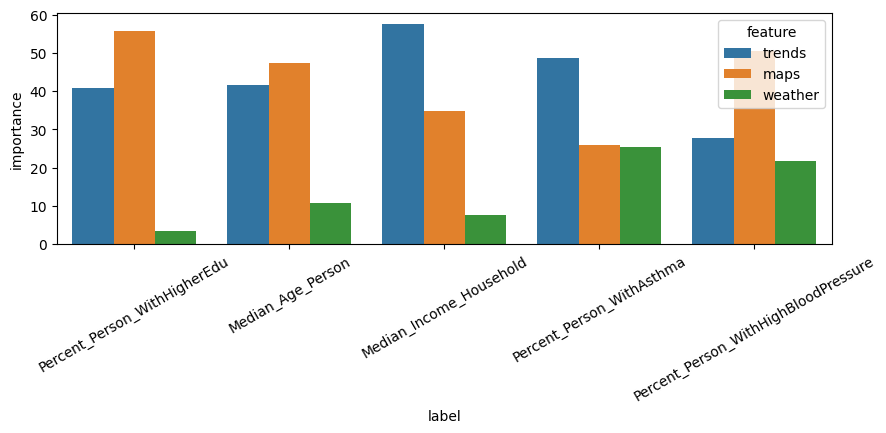

In [28]:
#@title LightGBM feature importance
import seaborn as sns
features = {
  'trends': (128, embedding_features[:128]),
  'maps': (128, embedding_features[128:256]),
  'weather': (74, embedding_features[256:]),
}
all_importance = []
for label, model in models_by_label_lgbm.items():
  importance = pd.DataFrame(model[1].feature_importances_,
                            index=embedding_features,
                            columns=['importance'])
  importance['importance'] = importance['importance'].abs()
  for feature, dims in features.items():
    importance.loc[dims[1], 'feature'] = feature
  importance = importance.groupby('feature').importance.sum().reset_index()
  importance['importance'] = (importance.importance /
                              importance.importance.sum() * 100)
  importance['label'] = label
  all_importance.append(importance)
all_importance = pd.concat(all_importance)
_, ax = plt.subplots(figsize=(10, 3))
sns.barplot(data=all_importance, x='label', y='importance',
            hue='feature',
            hue_order=features.keys(), ax=ax)
_ = plt.xticks(rotation=30)